## Look at BLING output

In [15]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import pickle
from mpl_toolkits.basemap import Basemap, cm
import cmocean

%matplotlib inline

In [16]:
color_CB  = '#c3e8de'
color_BB  = '#77b5fe'
color_CAA = '#766d5d'
color_LS  = '#86964f'

In [17]:
# BLING:

folder_EPM101 = '/ocean/brogalla/GEOTRACES/BLING-EPM101/'

dset = xr.open_dataset(folder_EPM101+'ANHA4-EPM101_y2002m08d13_gridB.nc')
ANHA4_lons = dset['nav_lon'].values
ANHA4_lats = dset['nav_lat'].values
ANHA4_depths = dset['deptht'].values

year=2002

file_range = [f'ANHA4-EPM101_y{year}m08d18_gridB.nc', f'ANHA4-EPM101_y{year}m08d23_gridB.nc', f'ANHA4-EPM101_y{year}m08d28_gridB.nc', \
              f'ANHA4-EPM101_y{year}m09d02_gridB.nc', f'ANHA4-EPM101_y{year}m09d07_gridB.nc', f'ANHA4-EPM101_y{year}m09d12_gridB.nc', \
              f'ANHA4-EPM101_y{year}m09d17_gridB.nc', f'ANHA4-EPM101_y{year}m09d22_gridB.nc', f'ANHA4-EPM101_y{year}m09d27_gridB.nc', \
              f'ANHA4-EPM101_y{year}m10d02_gridB.nc', f'ANHA4-EPM101_y{year}m10d07_gridB.nc']

biomass_p = np.zeros((50,800,544))
fpop_p    = np.zeros((50,800,544))
jp_pop    = np.zeros((50,800,544))
for n,file in enumerate(file_range):
    dset = xr.open_dataset(folder_EPM101+file)
    biomass_p = biomass_p + dset['biomass_p'][0,:,:,:].drop(labels=['time_centered', 'time_counter']).values
    fpop_p    = fpop_p    + dset['fpop'][0,:,:,:].drop(labels=['time_centered', 'time_counter']).values
    jp_pop    = jp_pop    + dset['jp_pop'] [0,:,:,:].drop(labels=['time_centered', 'time_counter']).values
    
biomass = biomass_p / n
fpop    = fpop_p / n
jppop   = jp_pop / n 

In [18]:
# # Interpolated:

# # folder_base = '/ocean/brogalla/GEOTRACES/data/Pb-tuning-202210/new-bio-proxy/general-particle-fields/'
# folder_base = '/ocean/brogalla/GEOTRACES/data/Pb-tuning-202210/new-bio-proxy/biomass-nonlinear-2-3-fpop-01-2/'
# year=2002 
# file_range = [f'Pb_scavenging_y{year}m{month:02}.nc' for month in range(8,11)]

# biomass_p = np.zeros((50,2400,1632))
# fpop_p    = np.zeros((50,2400,1632))
# for n,file in enumerate(file_range):
#     dset = xr.open_dataset(folder_base+file)
#     biomass_p = biomass_p + dset['biogenic'][:,:,:].values
# #     fpop_p    = fpop_p    + dset['fpop'][:,:,:].values
    
# biomass = biomass_p / n
# fpop    = fpop_p / n

In [19]:
mesh         = xr.open_dataset('/ocean/brogalla/GEOTRACES/data/ANHA12/ANHA12_mask_Pb-20220317.nc')
ANHA12_lon   = mesh['nav_lon'].values
ANHA12_lat   = mesh['nav_lat'].values

In [21]:
def remove_sinking(flux):
    # area --- grid cell area
    # flux --- mol P / m2 /s
    # dz   --- grid cell thickness 
    ANHA4_dz                 = np.diff(ANHA4_depths, prepend=0)
    wsink                    = np.ones(ANHA4_depths.shape)*16/(3600*24) # convert from m/day to m/s
    wsink[ANHA4_depths > 80] = (0.05*(ANHA4_depths[ANHA4_depths > 80]-80)+16)/(3600*24) 
    
    # mol P/m2/s * s/m --> mol P / m3 
    content = np.array([flux[d,:,:] * (1/wsink[d]) for d in range(0,len(ANHA4_depths))])

    return content

In [22]:
fpop_convert = remove_sinking(fpop)

In [12]:
# wsink                    = np.ones(ANHA4_depths.shape)*16/(3600*24) # convert from m/day to m/s
# wsink[ANHA4_depths > 80] = (0.05*(ANHA4_depths[ANHA4_depths > 80]-80)+16)/(3600*24) 
# jppop_convert            = np.array([jppop[d,:,:] / wsink[d] for d in range(0,len(ANHA4_depths))])
# fpop_convert             = np.array([fpop[d,:,:] / wsink[d] for d in range(0,len(ANHA4_depths))])

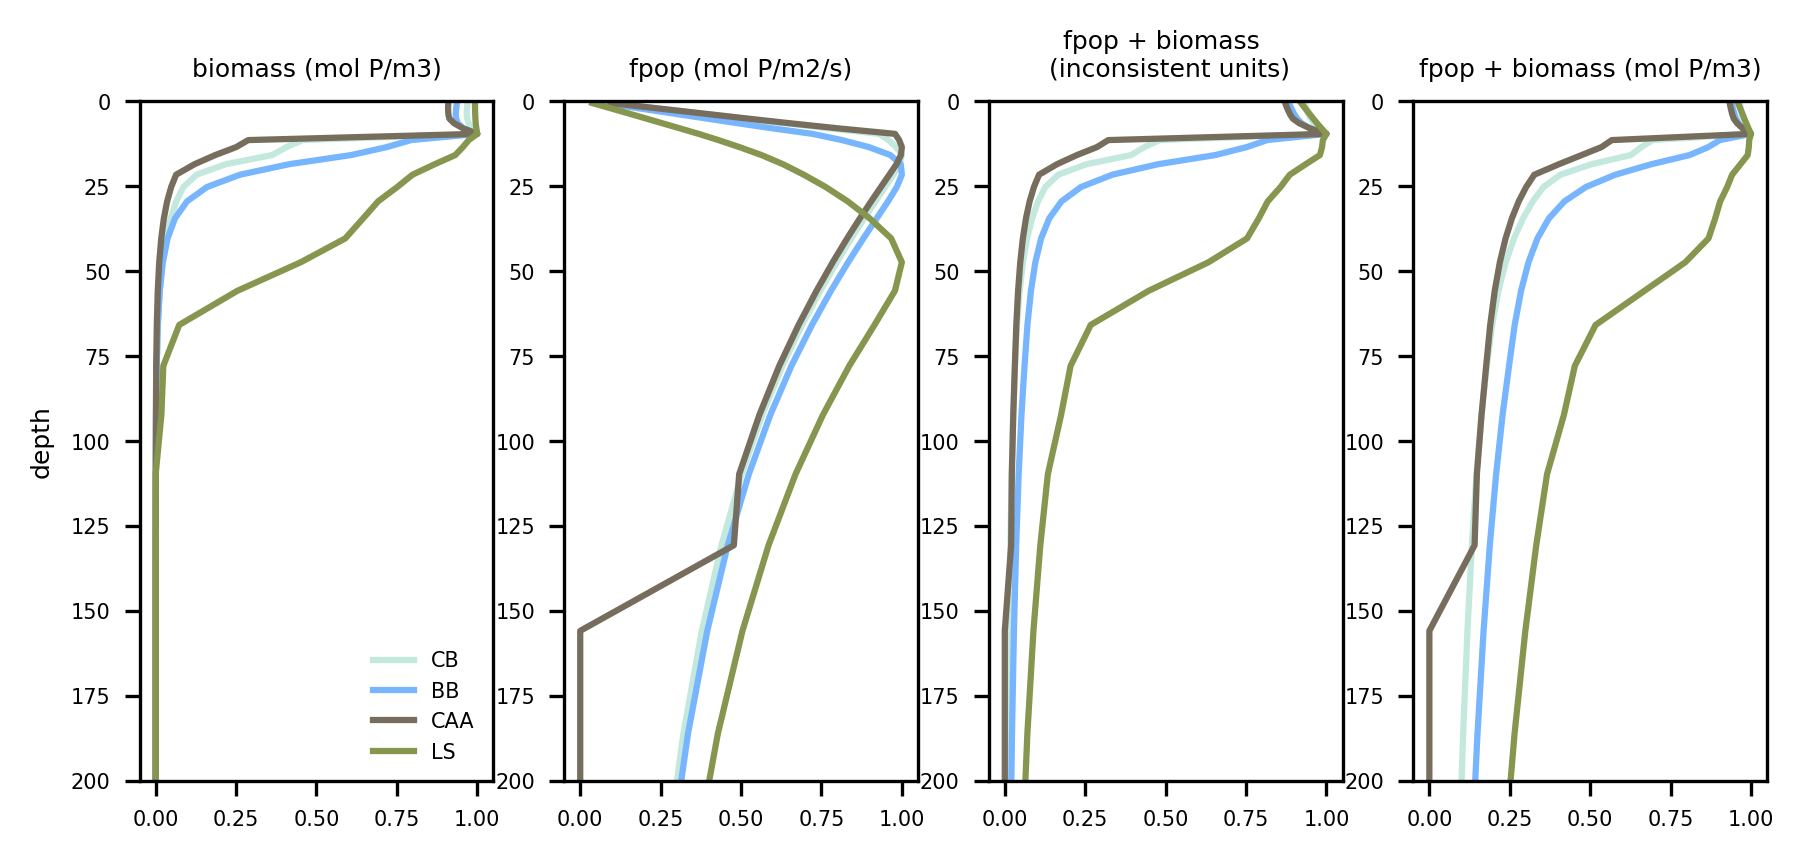

In [14]:
# Typical vertical profiles at the stations:
# CB  = (2020,600)
# BB  = (1450,600) 
# CAA = (1780,450) 
# LS  = (1200,550) 
CB  = (680,190)
BB  = (480,195)
CAA = (585,153)
LS  = (400,185)

fig, ax = plt.subplots(1,4, figsize=(7,3), dpi=300)

ax[0].set_ylabel('depth', fontsize=6)

for axis in ax.ravel():
    axis.set_ylim(200,0)
    axis.xaxis.get_offset_text().set_size(fontsize=6)
    axis.tick_params(axis='both', labelsize=5)

ax[0].set_title('biomass (mol P/m3)', fontsize=6)
ax[0].plot(biomass[:,CB[0],CB[1]]  / np.max(biomass[:,CB[0],CB[1]]), ANHA4_depths, c=color_CB, label='CB')
ax[0].plot(biomass[:,BB[0],BB[1]]  / np.max(biomass[:,BB[0],BB[1]]), ANHA4_depths, c=color_BB, label='BB')
ax[0].plot(biomass[:,CAA[0],CAA[1]]/ np.max(biomass[:,CAA[0],CAA[1]]), ANHA4_depths, c=color_CAA, label='CAA')
ax[0].plot(biomass[:,LS[0],LS[1]]  / np.max(biomass[:,LS[0],LS[1]]), ANHA4_depths, c=color_LS, label='LS')
ax[0].legend(fontsize=5, frameon=False)

ax[1].set_title('fpop (mol P/m2/s)', fontsize=6)
ax[1].plot(fpop[:,CB[0],CB[1]]  / np.max(fpop[:,CB[0],CB[1]]), ANHA4_depths, c=color_CB)
ax[1].plot(fpop[:,BB[0],BB[1]]  / np.max(fpop[:,BB[0],BB[1]]), ANHA4_depths, c=color_BB)
ax[1].plot(fpop[:,CAA[0],CAA[1]]/ np.max(fpop[:,CAA[0],CAA[1]]), ANHA4_depths, c=color_CAA)
ax[1].plot(fpop[:,LS[0],LS[1]]  / np.max(fpop[:,LS[0],LS[1]]), ANHA4_depths, c=color_LS)

ax[2].set_title('fpop + biomass \n (inconsistent units)', fontsize=6)
biogenic_lin1  = (biomass + fpop_convert)
ax[2].plot(biogenic_lin1[:,CB[0],CB[1]]/np.nanmax(biogenic_lin1[:,CB[0],CB[1]])  , ANHA4_depths, c=color_CB)
ax[2].plot(biogenic_lin1[:,BB[0],BB[1]]/np.nanmax(biogenic_lin1[:,BB[0],BB[1]])  , ANHA4_depths, c=color_BB)
ax[2].plot(biogenic_lin1[:,CAA[0],CAA[1]]/np.nanmax(biogenic_lin1[:,CAA[0],CAA[1]]), ANHA4_depths, c=color_CAA)
ax[2].plot(biogenic_lin1[:,LS[0],LS[1]]/np.nanmax(biogenic_lin1[:,LS[0],LS[1]])  , ANHA4_depths, c=color_LS)

ax[3].set_title('fpop + biomass (mol P/m3)', fontsize=6)
biogenic_lin2  = (biomass + fpop_convert)**(1/2.)
ax[3].plot(biogenic_lin2[:,CB[0],CB[1]]/np.nanmax(biogenic_lin2[:,CB[0],CB[1]])  , ANHA4_depths, c=color_CB)
ax[3].plot(biogenic_lin2[:,BB[0],BB[1]]/np.nanmax(biogenic_lin2[:,BB[0],BB[1]])  , ANHA4_depths, c=color_BB)
ax[3].plot(biogenic_lin2[:,CAA[0],CAA[1]]/np.nanmax(biogenic_lin2[:,CAA[0],CAA[1]]), ANHA4_depths, c=color_CAA)
ax[3].plot(biogenic_lin2[:,LS[0],LS[1]]/np.nanmax(biogenic_lin2[:,LS[0],LS[1]])  , ANHA4_depths, c=color_LS)

In [66]:
print(biogenic_lin1[:,CB[0],CB[1]]/np.max(biogenic_lin1[:,CB[0],CB[1]]))
print(biogenic_lin1[:,BB[0],BB[1]]/np.max(biogenic_lin1[:,BB[0],BB[1]]))
print(biogenic_lin1[:,CAA[0],CAA[1]]/np.max(biogenic_lin1[:,CAA[0],CAA[1]]))
print(biogenic_lin1[:,LS[0],LS[1]]/np.max(biogenic_lin1[:,LS[0],LS[1]]))

[7.96646846e-01 8.16256011e-01 8.37126186e-01 8.59711682e-01
 8.85681760e-01 9.15907793e-01 9.52284796e-01 1.00000000e+00
 5.71210325e-01 5.35813093e-01 5.04433038e-01 3.87528961e-01
 3.10136948e-01 2.72065177e-01 2.47857827e-01 2.26291076e-01
 2.06154387e-01 1.87374285e-01 1.69768926e-01 1.53085885e-01
 1.37189881e-01 1.22174640e-01 1.07841606e-01 9.40775325e-02
 8.09675755e-02 6.86703666e-02 5.73758611e-02 4.72430261e-02
 3.83680836e-02 3.07714281e-02 2.44081347e-02 1.91820181e-02
 1.49643167e-02 1.16116371e-02 8.98021433e-03 6.93598134e-03
 5.36020679e-03 4.15216738e-03 3.22907452e-03 2.52469422e-03
 1.98695126e-03 1.57548925e-03 1.25949064e-03 1.01562103e-03
 9.36140294e-04 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
[0.70438002 0.73179066 0.7607317  0.79181591 0.82615925 0.86693296
 0.92050108 1.         0.88652067 0.86391522 0.80978955 0.68296631
 0.57346899 0.49348719 0.43796565 0.3975134  0.36492302 0.33606391
 0.30868518 0.2816076  0.25452729 0

In [67]:
print(biogenic_lin2[:,CB[0],CB[1]]/np.max(biogenic_lin2[:,CB[0],CB[1]]))
print(biogenic_lin2[:,BB[0],BB[1]]/np.max(biogenic_lin2[:,BB[0],BB[1]]))
print(biogenic_lin2[:,CAA[0],CAA[1]]/np.max(biogenic_lin2[:,CAA[0],CAA[1]]))
print(biogenic_lin2[:,LS[0],LS[1]]/np.max(biogenic_lin2[:,LS[0],LS[1]]))

[0.96572569 0.96734603 0.96924292 0.97156833 0.97515748 0.98028788
 0.987745   1.         0.69380613 0.65886044 0.62674025 0.50454738
 0.40760809 0.35490668 0.32147979 0.29141968 0.2632347  0.23751571
 0.21472337 0.19510739 0.17862297 0.16198438 0.14660316 0.13219152
 0.11837994 0.10499876 0.09211259 0.07990326 0.06856548 0.05824927
 0.04904493 0.04098114 0.03403266 0.02813269 0.02318638 0.01908369
 0.01570985 0.01295365 0.01071252 0.00889559 0.00742447 0.00623295
 0.00526629 0.00447985 0.0040847  0.         0.         0.
 0.         0.        ]
[0.93963976 0.94235578 0.94535093 0.94884881 0.95334433 0.96054397
 0.9738593  1.         0.90314469 0.86727408 0.80923772 0.69094135
 0.57805212 0.48681761 0.41982703 0.3717877  0.33611276 0.30817744
 0.28512345 0.26529947 0.24774382 0.2276363  0.20757689 0.18794837
 0.16859267 0.14960649 0.13125705 0.11386268 0.0977118  0.08301891
 0.06991159 0.05842959 0.04853817 0.04013949 0.03309803 0.02725706
 0.02245344 0.01852866 0.01533606 0.01274566 0

In [31]:
print(fpop[:,CB[0],CB[1]]   / np.max(fpop[:,CB[0],CB[1]]))
print(fpop_convert[:,CB[0],CB[1]]   / np.max(fpop_convert[:,CB[0],CB[1]]))
# print(fpop_convert[:,BB[0],BB[1]]   / np.max(fpop_convert[:,BB[0],BB[1]]))
# print(fpop_convert[:,CAA[0],CAA[1]] / np.max(fpop_convert[:,CAA[0],CAA[1]]))
# print(fpop_convert[:,LS[0],LS[1]]   / np.max(fpop_convert[:,LS[0],LS[1]]))

[0.09296458 0.18960863 0.29085008 0.39785307 0.51233521 0.63653476
 0.77362371 0.92912093 0.95834846 0.98196999 1.         0.99291154
 0.97351221 0.94820009 0.91810329 0.88310587 0.84296    0.79742272
 0.74633021 0.68968795 0.62858194 0.56556993 0.50190158 0.43895
 0.37813033 0.32078221 0.26803534 0.22070061 0.17924051 0.14375195
 0.11402516 0.08961081 0.06990737 0.05424498 0.04195201 0.03240216
 0.02504077 0.01939728 0.01508496 0.01179437 0.00928225 0.00736006
 0.00588384 0.00474458 0.00437328 0.         0.         0.
 0.         0.        ]
[9.29645835e-02 1.89608633e-01 2.90850083e-01 3.97853070e-01
 5.12335208e-01 6.36534763e-01 7.73623711e-01 9.29120928e-01
 9.58348457e-01 9.81969990e-01 1.00000000e+00 9.92911536e-01
 9.73512207e-01 9.48200094e-01 9.18103293e-01 8.83105869e-01
 8.42960000e-01 7.97422722e-01 7.46330213e-01 6.89687951e-01
 6.28581936e-01 5.44592753e-01 4.59236669e-01 3.78950355e-01
 3.05675099e-01 2.40892156e-01 1.85461439e-01 1.39562399e-01
 1.02766788e-01 7.416907

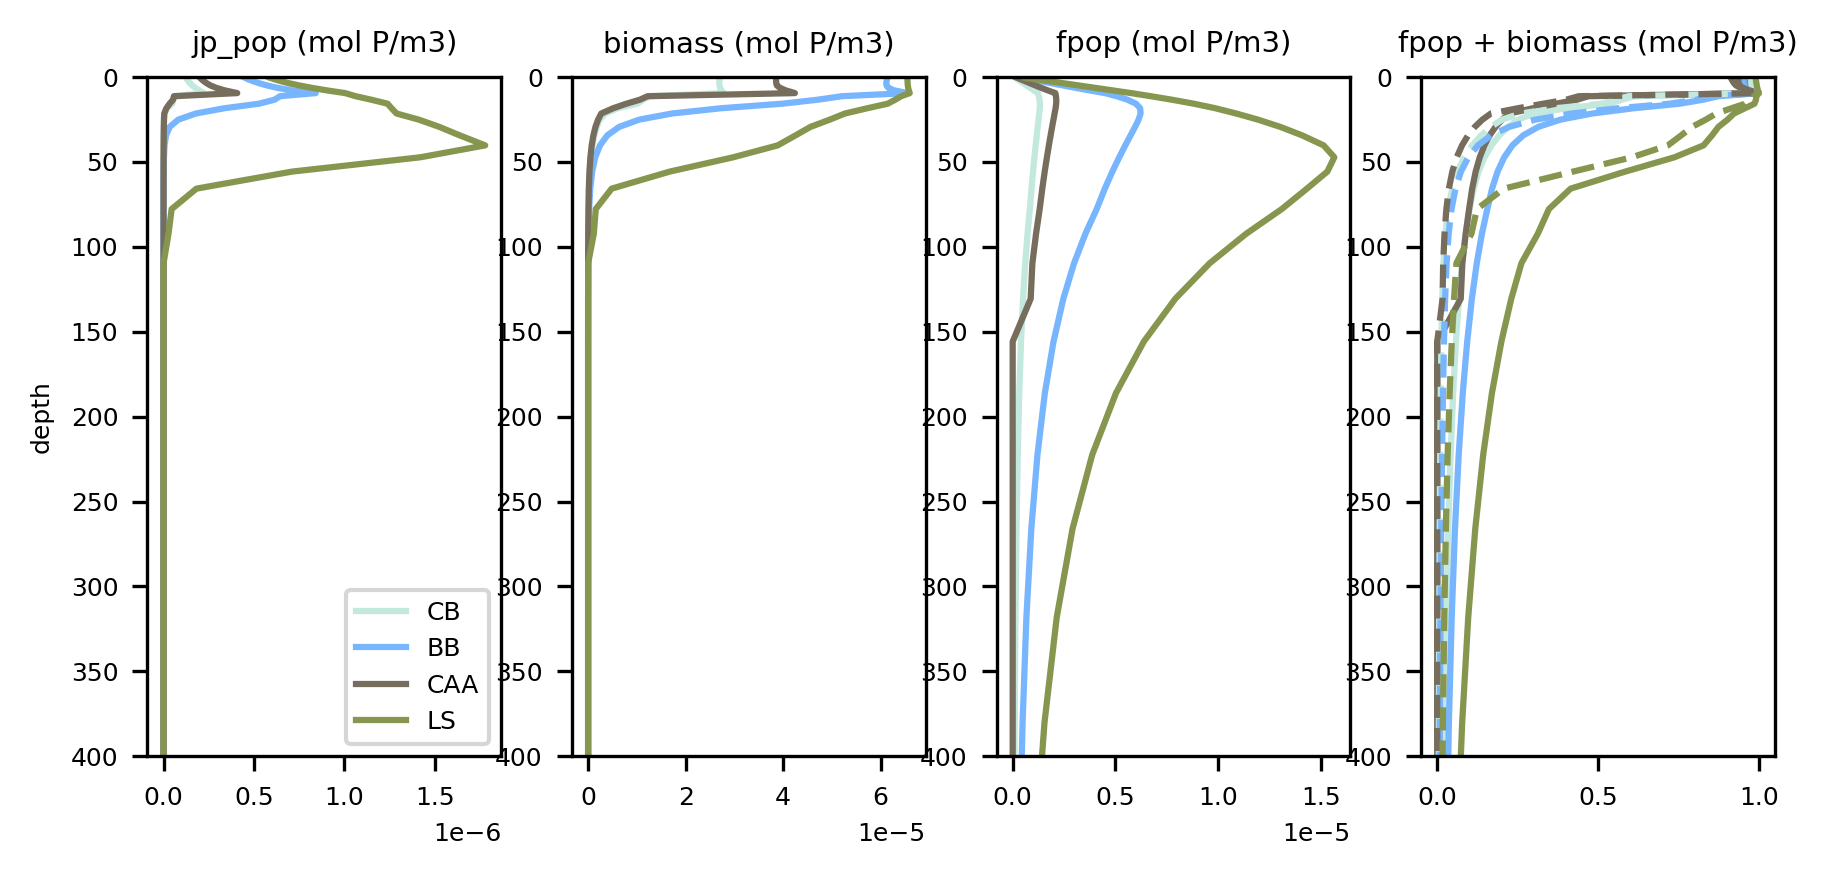

In [19]:
# Typical vertical profiles at the stations:
CB  = (680,190)
BB  = (480,195)
CAA = (585,153)
LS  = (400,185)

fig, ax = plt.subplots(1,4, figsize=(7,3), dpi=300)

ax[0].set_ylabel('depth', fontsize=6)

for axis in ax.ravel():
    axis.set_ylim(400,0)
    axis.xaxis.get_offset_text().set_size(fontsize=6)
    axis.tick_params(axis='both', labelsize=6)
    
ax[0].set_title('jp_pop (mol P/m3)', fontsize=7)
ax[0].plot(jppop_convert[:,CB[0],CB[1]]  , ANHA4_depths, c=color_CB, label='CB')
ax[0].plot(jppop_convert[:,BB[0],BB[1]]  , ANHA4_depths, c=color_BB, label='BB')
ax[0].plot(jppop_convert[:,CAA[0],CAA[1]], ANHA4_depths, c=color_CAA, label='CAA')
ax[0].plot(jppop_convert[:,LS[0],LS[1]]  , ANHA4_depths, c=color_LS, label='LS')
ax[0].legend(loc=4, fontsize=6)

ax[1].set_title('biomass (mol P/m3)', fontsize=7)
ax[1].plot(biomass[:,CB[0],CB[1]]  , ANHA4_depths, c=color_CB)
ax[1].plot(biomass[:,BB[0],BB[1]]  , ANHA4_depths, c=color_BB)
ax[1].plot(biomass[:,CAA[0],CAA[1]], ANHA4_depths, c=color_CAA)
ax[1].plot(biomass[:,LS[0],LS[1]]  , ANHA4_depths, c=color_LS)

ax[2].set_title('fpop (mol P/m3)', fontsize=7)
ax[2].plot(fpop_convert[:,CB[0],CB[1]]  , ANHA4_depths, c=color_CB)
ax[2].plot(fpop_convert[:,BB[0],BB[1]]  , ANHA4_depths, c=color_BB)
ax[2].plot(fpop_convert[:,CAA[0],CAA[1]], ANHA4_depths, c=color_CAA)
ax[2].plot(fpop_convert[:,LS[0],LS[1]]  , ANHA4_depths, c=color_LS)

ax[3].set_title('fpop + biomass (mol P/m3)', fontsize=7)
biogenic_nonlin = (biomass + fpop_convert)**(2/3.)
biogenic_lin    = (biomass + 0.1*fpop_convert)**(2/3.)
ax[3].plot(biogenic_nonlin[:,CB[0],CB[1]]   / np.max(biogenic_nonlin[:,CB[0],CB[1]])   , ANHA4_depths, c=color_CB)
ax[3].plot(biogenic_nonlin[:,BB[0],BB[1]]   / np.max(biogenic_nonlin[:,BB[0],BB[1]])   , ANHA4_depths, c=color_BB)
ax[3].plot(biogenic_nonlin[:,CAA[0],CAA[1]] / np.max(biogenic_nonlin[:,CAA[0],CAA[1]]) , ANHA4_depths, c=color_CAA)
ax[3].plot(biogenic_nonlin[:,LS[0],LS[1]]   / np.max(biogenic_nonlin[:,LS[0],LS[1]])   , ANHA4_depths, c=color_LS)
ax[3].plot(biogenic_lin[:,CB[0],CB[1]]   / np.max(biogenic_lin[:,CB[0],CB[1]])   , ANHA4_depths, '--', c=color_CB)
ax[3].plot(biogenic_lin[:,BB[0],BB[1]]   / np.max(biogenic_lin[:,BB[0],BB[1]])   , ANHA4_depths, '--', c=color_BB)
ax[3].plot(biogenic_lin[:,CAA[0],CAA[1]] / np.max(biogenic_lin[:,CAA[0],CAA[1]]) , ANHA4_depths, '--', c=color_CAA)
ax[3].plot(biogenic_lin[:,LS[0],LS[1]]   / np.max(biogenic_lin[:,LS[0],LS[1]])   , ANHA4_depths, '--', c=color_LS)

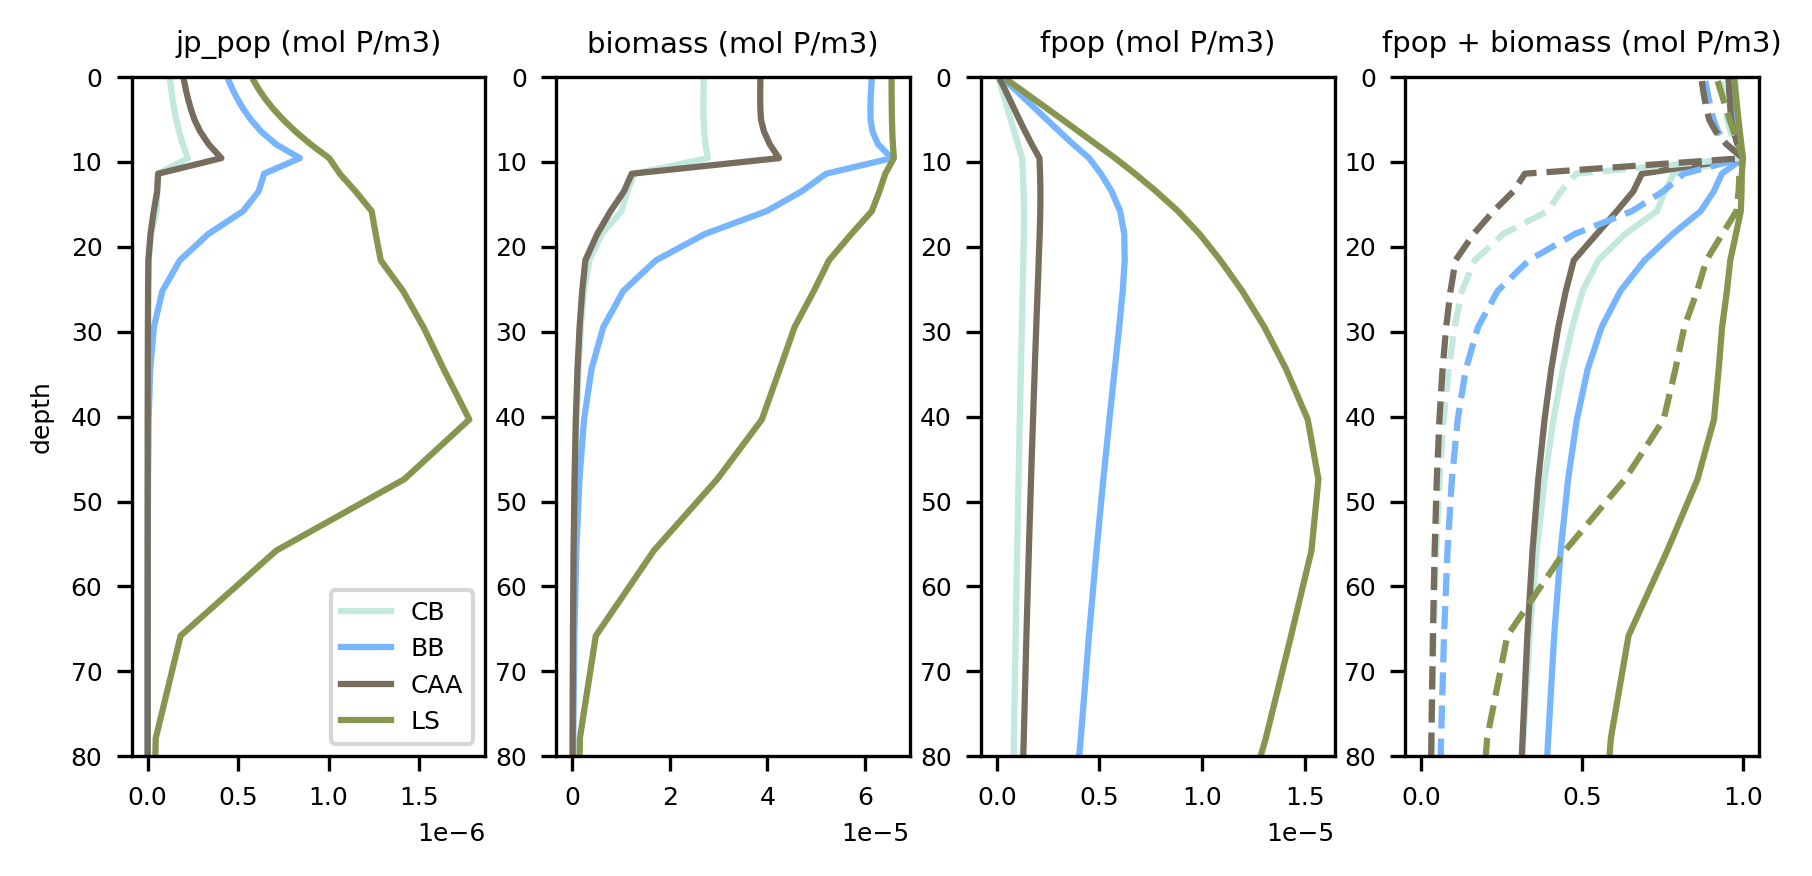

In [9]:
# Typical vertical profiles at the stations:
CB  = (680,190)
BB  = (480,195)
CAA = (585,153)
LS  = (400,185)

fig, ax = plt.subplots(1,4, figsize=(7,3), dpi=300)

ax[0].set_ylabel('depth', fontsize=6)

for axis in ax.ravel():
    axis.set_ylim(80,0)
    axis.xaxis.get_offset_text().set_size(fontsize=6)
    axis.tick_params(axis='both', labelsize=6)
    
ax[0].set_title('jp_pop (mol P/m3)', fontsize=7)
ax[0].plot(jppop_convert[:,CB[0],CB[1]]  , ANHA4_depths, c=color_CB, label='CB')
ax[0].plot(jppop_convert[:,BB[0],BB[1]]  , ANHA4_depths, c=color_BB, label='BB')
ax[0].plot(jppop_convert[:,CAA[0],CAA[1]], ANHA4_depths, c=color_CAA, label='CAA')
ax[0].plot(jppop_convert[:,LS[0],LS[1]]  , ANHA4_depths, c=color_LS, label='LS')
ax[0].legend(loc=4, fontsize=6)

ax[1].set_title('biomass (mol P/m3)', fontsize=7)
ax[1].plot(biomass[:,CB[0],CB[1]]  , ANHA4_depths, c=color_CB)
ax[1].plot(biomass[:,BB[0],BB[1]]  , ANHA4_depths, c=color_BB)
ax[1].plot(biomass[:,CAA[0],CAA[1]], ANHA4_depths, c=color_CAA)
ax[1].plot(biomass[:,LS[0],LS[1]]  , ANHA4_depths, c=color_LS)

ax[2].set_title('fpop (mol P/m3)', fontsize=7)
ax[2].plot(fpop_convert[:,CB[0],CB[1]]  , ANHA4_depths, c=color_CB)
ax[2].plot(fpop_convert[:,BB[0],BB[1]]  , ANHA4_depths, c=color_BB)
ax[2].plot(fpop_convert[:,CAA[0],CAA[1]], ANHA4_depths, c=color_CAA)
ax[2].plot(fpop_convert[:,LS[0],LS[1]]  , ANHA4_depths, c=color_LS)

ax[3].set_title('fpop + biomass (mol P/m3)', fontsize=7)
biogenic_nonlin = (biomass + fpop_convert)**(1/3.)
biogenic_lin    = (biomass + fpop_convert)
ax[3].plot(biogenic_nonlin[:,CB[0],CB[1]]   / np.max(biogenic_nonlin[:,CB[0],CB[1]])   , ANHA4_depths, c=color_CB)
ax[3].plot(biogenic_nonlin[:,BB[0],BB[1]]   / np.max(biogenic_nonlin[:,BB[0],BB[1]])   , ANHA4_depths, c=color_BB)
ax[3].plot(biogenic_nonlin[:,CAA[0],CAA[1]] / np.max(biogenic_nonlin[:,CAA[0],CAA[1]]) , ANHA4_depths, c=color_CAA)
ax[3].plot(biogenic_nonlin[:,LS[0],LS[1]]   / np.max(biogenic_nonlin[:,LS[0],LS[1]])   , ANHA4_depths, c=color_LS)
ax[3].plot(biogenic_lin[:,CB[0],CB[1]]   / np.max(biogenic_lin[:,CB[0],CB[1]])   , ANHA4_depths, '--', c=color_CB)
ax[3].plot(biogenic_lin[:,BB[0],BB[1]]   / np.max(biogenic_lin[:,BB[0],BB[1]])   , ANHA4_depths, '--', c=color_BB)
ax[3].plot(biogenic_lin[:,CAA[0],CAA[1]] / np.max(biogenic_lin[:,CAA[0],CAA[1]]) , ANHA4_depths, '--', c=color_CAA)
ax[3].plot(biogenic_lin[:,LS[0],LS[1]]   / np.max(biogenic_lin[:,LS[0],LS[1]])   , ANHA4_depths, '--', c=color_LS)

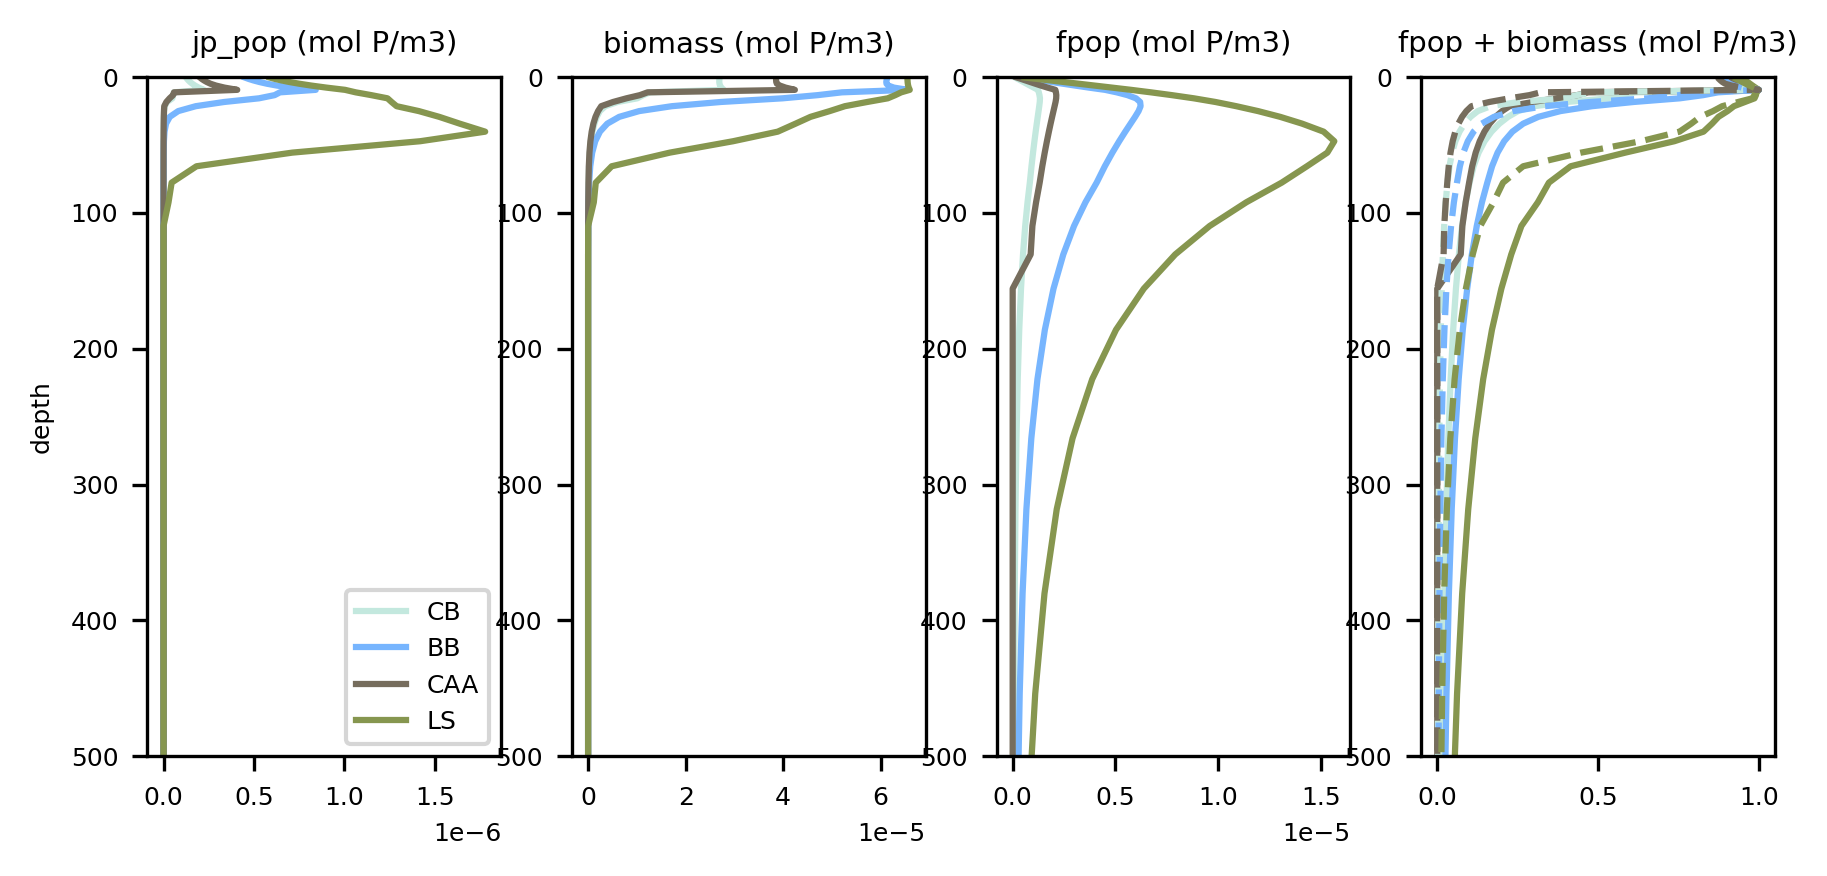

In [20]:
# Typical vertical profiles at the stations:
CB  = (680,190)
BB  = (480,195)
CAA = (585,153)
LS  = (400,185)

fig, ax = plt.subplots(1,4, figsize=(7,3), dpi=300)

ax[0].set_ylabel('depth', fontsize=6)

for axis in ax.ravel():
    axis.set_ylim(500,0)
    axis.xaxis.get_offset_text().set_size(fontsize=6)
    axis.tick_params(axis='both', labelsize=6)
    
ax[0].set_title('jp_pop (mol P/m3)', fontsize=7)
ax[0].plot(jppop_convert[:,CB[0],CB[1]]  , ANHA4_depths, c=color_CB, label='CB')
ax[0].plot(jppop_convert[:,BB[0],BB[1]]  , ANHA4_depths, c=color_BB, label='BB')
ax[0].plot(jppop_convert[:,CAA[0],CAA[1]], ANHA4_depths, c=color_CAA, label='CAA')
ax[0].plot(jppop_convert[:,LS[0],LS[1]]  , ANHA4_depths, c=color_LS, label='LS')
ax[0].legend(loc=4, fontsize=6)

ax[1].set_title('biomass (mol P/m3)', fontsize=7)
ax[1].plot(biomass[:,CB[0],CB[1]]  , ANHA4_depths, c=color_CB)
ax[1].plot(biomass[:,BB[0],BB[1]]  , ANHA4_depths, c=color_BB)
ax[1].plot(biomass[:,CAA[0],CAA[1]], ANHA4_depths, c=color_CAA)
ax[1].plot(biomass[:,LS[0],LS[1]]  , ANHA4_depths, c=color_LS)

ax[2].set_title('fpop (mol P/m3)', fontsize=7)
ax[2].plot(fpop_convert[:,CB[0],CB[1]]  , ANHA4_depths, c=color_CB)
ax[2].plot(fpop_convert[:,BB[0],BB[1]]  , ANHA4_depths, c=color_BB)
ax[2].plot(fpop_convert[:,CAA[0],CAA[1]], ANHA4_depths, c=color_CAA)
ax[2].plot(fpop_convert[:,LS[0],LS[1]]  , ANHA4_depths, c=color_LS)

ax[3].set_title('fpop + biomass (mol P/m3)', fontsize=7)
biogenic_nonlin = (biomass + fpop_convert)**(2/3.)
biogenic_lin    = (biomass + fpop_convert)
ax[3].plot(biogenic_nonlin[:,CB[0],CB[1]]   / np.max(biogenic_nonlin[:,CB[0],CB[1]])   , ANHA4_depths, c=color_CB)
ax[3].plot(biogenic_nonlin[:,BB[0],BB[1]]   / np.max(biogenic_nonlin[:,BB[0],BB[1]])   , ANHA4_depths, c=color_BB)
ax[3].plot(biogenic_nonlin[:,CAA[0],CAA[1]] / np.max(biogenic_nonlin[:,CAA[0],CAA[1]]) , ANHA4_depths, c=color_CAA)
ax[3].plot(biogenic_nonlin[:,LS[0],LS[1]]   / np.max(biogenic_nonlin[:,LS[0],LS[1]])   , ANHA4_depths, c=color_LS)
ax[3].plot(biogenic_lin[:,CB[0],CB[1]]   / np.max(biogenic_lin[:,CB[0],CB[1]])   , ANHA4_depths, '--', c=color_CB)
ax[3].plot(biogenic_lin[:,BB[0],BB[1]]   / np.max(biogenic_lin[:,BB[0],BB[1]])   , ANHA4_depths, '--', c=color_BB)
ax[3].plot(biogenic_lin[:,CAA[0],CAA[1]] / np.max(biogenic_lin[:,CAA[0],CAA[1]]) , ANHA4_depths, '--', c=color_CAA)
ax[3].plot(biogenic_lin[:,LS[0],LS[1]]   / np.max(biogenic_lin[:,LS[0],LS[1]])   , ANHA4_depths, '--', c=color_LS)

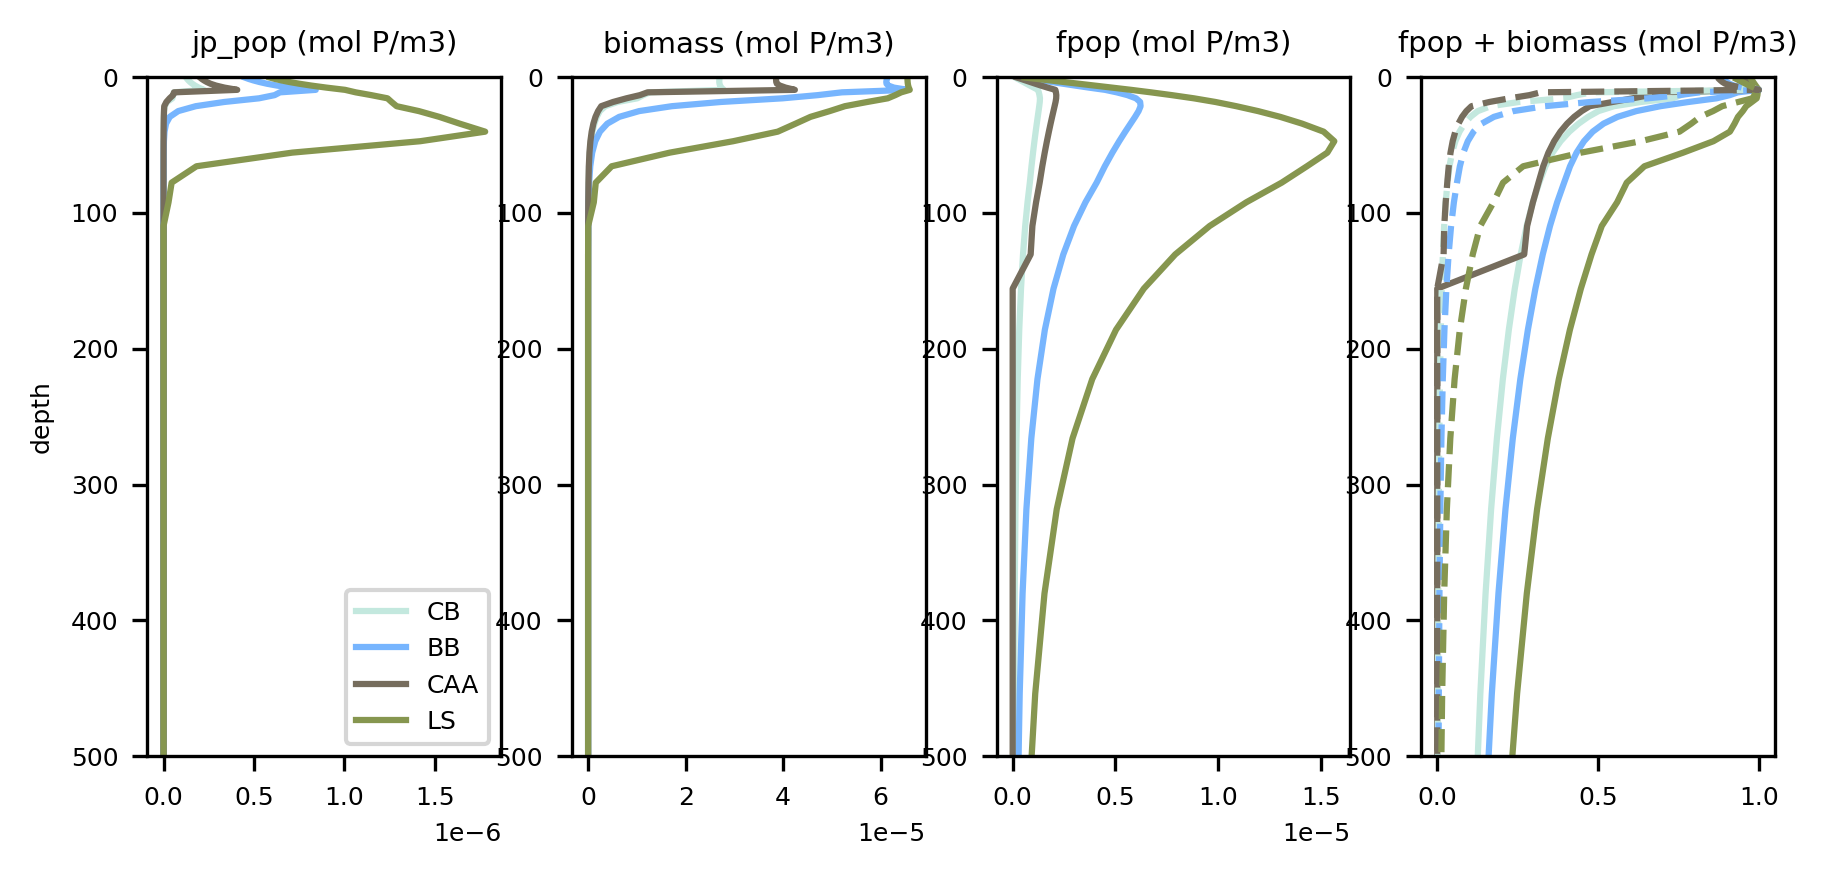

In [10]:
# Typical vertical profiles at the stations:
CB  = (680,190)
BB  = (480,195)
CAA = (585,153)
LS  = (400,185)

fig, ax = plt.subplots(1,4, figsize=(7,3), dpi=300)

ax[0].set_ylabel('depth', fontsize=6)

for axis in ax.ravel():
    axis.set_ylim(500,0)
    axis.xaxis.get_offset_text().set_size(fontsize=6)
    axis.tick_params(axis='both', labelsize=6)
    
ax[0].set_title('jp_pop (mol P/m3)', fontsize=7)
ax[0].plot(jppop_convert[:,CB[0],CB[1]]  , ANHA4_depths, c=color_CB, label='CB')
ax[0].plot(jppop_convert[:,BB[0],BB[1]]  , ANHA4_depths, c=color_BB, label='BB')
ax[0].plot(jppop_convert[:,CAA[0],CAA[1]], ANHA4_depths, c=color_CAA, label='CAA')
ax[0].plot(jppop_convert[:,LS[0],LS[1]]  , ANHA4_depths, c=color_LS, label='LS')
ax[0].legend(loc=4, fontsize=6)

ax[1].set_title('biomass (mol P/m3)', fontsize=7)
ax[1].plot(biomass[:,CB[0],CB[1]]  , ANHA4_depths, c=color_CB)
ax[1].plot(biomass[:,BB[0],BB[1]]  , ANHA4_depths, c=color_BB)
ax[1].plot(biomass[:,CAA[0],CAA[1]], ANHA4_depths, c=color_CAA)
ax[1].plot(biomass[:,LS[0],LS[1]]  , ANHA4_depths, c=color_LS)

ax[2].set_title('fpop (mol P/m3)', fontsize=7)
ax[2].plot(fpop_convert[:,CB[0],CB[1]]  , ANHA4_depths, c=color_CB)
ax[2].plot(fpop_convert[:,BB[0],BB[1]]  , ANHA4_depths, c=color_BB)
ax[2].plot(fpop_convert[:,CAA[0],CAA[1]], ANHA4_depths, c=color_CAA)
ax[2].plot(fpop_convert[:,LS[0],LS[1]]  , ANHA4_depths, c=color_LS)

ax[3].set_title('fpop + biomass (mol P/m3)', fontsize=7)
biogenic_nonlin = (biomass + fpop_convert)**(1/3.)
biogenic_lin    = (biomass + fpop_convert)
ax[3].plot(biogenic_nonlin[:,CB[0],CB[1]]   / np.max(biogenic_nonlin[:,CB[0],CB[1]])   , ANHA4_depths, c=color_CB)
ax[3].plot(biogenic_nonlin[:,BB[0],BB[1]]   / np.max(biogenic_nonlin[:,BB[0],BB[1]])   , ANHA4_depths, c=color_BB)
ax[3].plot(biogenic_nonlin[:,CAA[0],CAA[1]] / np.max(biogenic_nonlin[:,CAA[0],CAA[1]]) , ANHA4_depths, c=color_CAA)
ax[3].plot(biogenic_nonlin[:,LS[0],LS[1]]   / np.max(biogenic_nonlin[:,LS[0],LS[1]])   , ANHA4_depths, c=color_LS)
ax[3].plot(biogenic_lin[:,CB[0],CB[1]]   / np.max(biogenic_lin[:,CB[0],CB[1]])   , ANHA4_depths, '--', c=color_CB)
ax[3].plot(biogenic_lin[:,BB[0],BB[1]]   / np.max(biogenic_lin[:,BB[0],BB[1]])   , ANHA4_depths, '--', c=color_BB)
ax[3].plot(biogenic_lin[:,CAA[0],CAA[1]] / np.max(biogenic_lin[:,CAA[0],CAA[1]]) , ANHA4_depths, '--', c=color_CAA)
ax[3].plot(biogenic_lin[:,LS[0],LS[1]]   / np.max(biogenic_lin[:,LS[0],LS[1]])   , ANHA4_depths, '--', c=color_LS)

In [34]:
def plot_slicemap(variable, depth_slice, vmin=0, vmax=1e-9, cmap=cmocean.cm.matter):
    fig, ax, proj = pickle.load(open('/ocean/brogalla/GEOTRACES/pickles/pb-surface.pickle','rb'))

    x, y = proj(ANHA4_lons, ANHA4_lats)

    cb = proj.contourf(x, y, variable[depth_slice,:,:], cmap=cmap, vmin=vmin, vmax=vmax, levels=20)
    
    proj.scatter(x[680,190], y[680,190], c='c', zorder=5, s=20) # Canada basin
    proj.scatter(x[480,195], y[480,195], c='g', zorder=5, s=20) # baffin bay
    proj.scatter(x[585,153], y[585,153], c='y', zorder=5, s=20) # CAA
    proj.scatter(x[400,185], y[400,185], c='r', zorder=5, s=20) # labrador sea
    
    cbaxes  = fig.add_axes([0.95, 0.15, 0.02, 0.7]) 
    CBar    = plt.colorbar(cb , ax=ax, cax=cbaxes, format='%.2e') 
    CBar.ax.tick_params(axis='y', length=0, labelsize=6)
    CBar.set_label('fPOP', fontsize=7)
    
    return

In [32]:
fpop_plt = np.ma.masked_where(np.isnan(fpop), fpop)

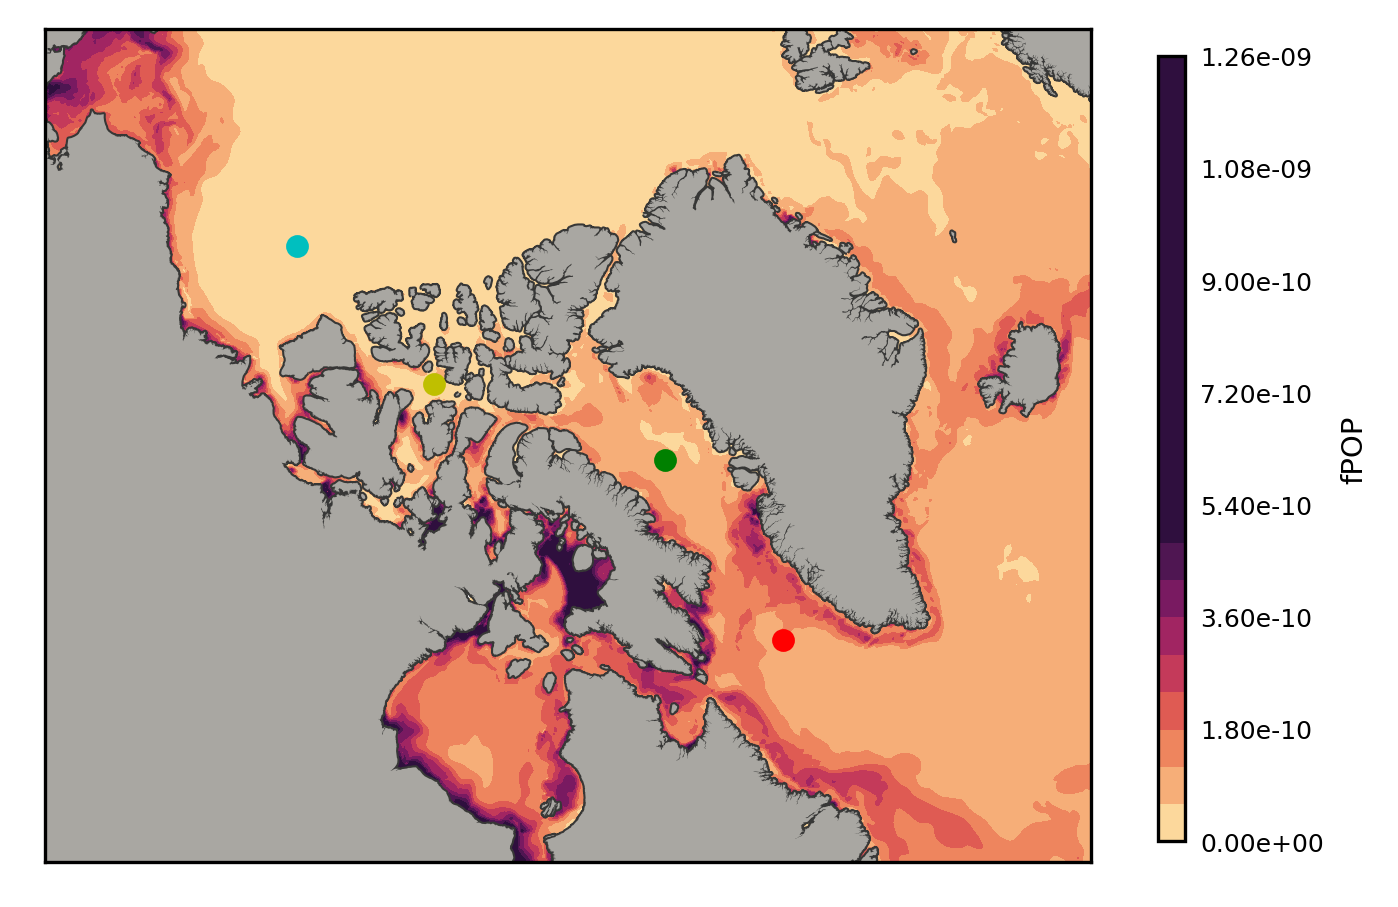

In [38]:
plot_slicemap(fpop_plt, 0, vmax=5e-10)